######### Epoch: 0  ######### Train Loss: 0.035815801937133074  ######### Relative L2 val Norm: 101.94906997680664
######### Epoch: 5  ######### Train Loss: 0.027951008873060346  ######### Relative L2 val Norm: 93.91719341278076
######### Epoch: 10  ######### Train Loss: 0.02263295277953148  ######### Relative L2 val Norm: 83.29641151428223
######### Epoch: 15  ######### Train Loss: 0.01594519999343902  ######### Relative L2 val Norm: 69.16388034820557
######### Epoch: 20  ######### Train Loss: 0.007521672232542187  ######### Relative L2 val Norm: 47.3722710609436
######### Epoch: 25  ######### Train Loss: 0.0038540672103408724  ######### Relative L2 val Norm: 34.97775220870972
######### Epoch: 30  ######### Train Loss: 0.0027372638578526676  ######### Relative L2 val Norm: 31.350069999694824
######### Epoch: 35  ######### Train Loss: 0.0021816744265379384  ######### Relative L2 val Norm: 28.94396734237671
######### Epoch: 40  ######### Train Loss: 0.0018694328318815678  ######### Rela

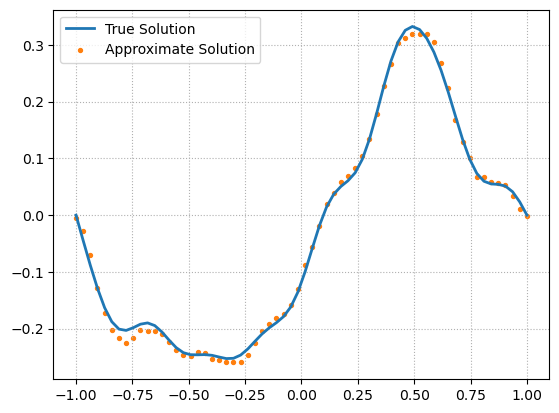

In [200]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

class SpectralConv1d(nn.Module):
    """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
    """
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        return torch.fft.irfft(out_ft, n=x.size(-1))


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w;
            K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x) --> GRID IS INCLUDED!

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.ReLU()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        #print("x1", x.shape)
        x = self.linear_p(x)
        #print("x2", x.shape)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic
        #print("x3", x.shape)
        x = self.fourier_layer(x, self.spect1, self.lin0)
        #print("x4", x.shape)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        #print("x5", x.shape)
        x = self.fourier_layer(x, self.spect3, self.lin2)
        #print("x6", x.shape)
        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        #print("x7", x.shape)
        x = self.linear_layer(x, self.linear_q)
        #print("x8", x.shape)
        x = self.output_layer(x)
        #print("x9", x.shape)
        return x


torch.manual_seed(0)
np.random.seed(0)


n_train = 64 # number of training samples


# Load training solution data
train_data = np.load("train_sol.npy", allow_pickle=True)

# Extract first (t=0) and last (t=1) time snapshots
n_trajectories = train_data.shape[0]
n_spatial_points = train_data.shape[2]

# Initialize arrays for input (t=0) and output (t=1)
x_data = np.zeros((n_trajectories, n_spatial_points, 2))  # 2 for [u(t=0), x]
y_data = np.zeros((n_trajectories, n_spatial_points))     # u(t=1)

# Fill the arrays
for i in range(n_trajectories):
    x_data[i, :, 0] = train_data[i, 0, :]    # u(t=0)
    x_data[i, :, 1] = np.linspace(-1, 1, n_spatial_points)  # spatial grid
    y_data[i, :] = train_data[i, -1, :]      # u(t=1)

# Convert to PyTorch tensors
x_data = torch.from_numpy(x_data).type(torch.float32)
y_data = torch.from_numpy(y_data).type(torch.float32)
# we train on the first 64 samples, the rest remains for validation
input_function_train = x_data[:n_train, :]
output_function_train = y_data[:n_train, :]
# we want to get the l2 error on the remaining 64 but test the final result on all 128
input_function_val = x_data[n_train:, :]
output_function_val = y_data[n_train:, :]


batch_size = 8

training_set = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=batch_size, shuffle=True)
testing_set = DataLoader(TensorDataset(input_function_val, output_function_val), batch_size=batch_size, shuffle=False)

id_sample = 32

# NOTE: THIS IS WHAT THE DATA LOOKS LIKE
#plt.plot(np.linspace(-1,1,input_function_train.shape[1]),input_function_train[id_sample,:,0], label = "input:   $u(t = 0)$")
#plt.plot(np.linspace(-1,1,input_function_train.shape[1]),output_function_train[id_sample,:], label = "output: $u(t = 1)$")
#plt.grid(True, which="both", ls=":")
#plt.legend()

modes = 10
width = 35
fno = FNO1d(modes, width) # model

# set up the optimizer
learning_rate = 0.0002
epochs = 250 # = 250
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)


l = torch.nn.MSELoss()
freq_print = 5
for epoch in range(epochs):
    fno.train()
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)


    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 val Norm:", test_relative_l2)


# test is both the training and the validation
input_function_test_n = torch.cat((input_function_train, input_function_val), dim=0)
output_function_test_n = torch.cat((output_function_train, output_function_val), dim =0)
output_function_test_pred_n = fno(input_function_test_n)

plt.figure()
plt.grid(True, which="both", ls=":")
plt.plot(input_function_test_n[0,:,1].detach(), output_function_test_n[0].detach(), label="True Solution", c="C0", lw=2)
plt.scatter(input_function_test_n[0,:,1].detach(), output_function_test_pred_n[0].detach(), label="Approximate Solution", s=8, c="C1")

# Lp norm for p = 2
p = 2
err = (torch.mean(abs(output_function_test_n.detach().reshape(-1, ) - output_function_test_pred_n.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_test_n.detach()) ** p)) ** (1 / p) * 100
print("Relative L2 error: ", err.item())
plt.legend()
plt.show()



# TASK 2: Testing on Different Resolutions


current res =  32
x_data.shape:  (128, 32, 2)
relatinve error for res =  32
Relative L2 error:  13.055293083190918
current res =  64
x_data.shape:  (128, 64, 2)
relatinve error for res =  64
Relative L2 error:  11.796426773071289
current res =  96
x_data.shape:  (128, 96, 2)
relatinve error for res =  96
Relative L2 error:  11.393857955932617
current res =  128
x_data.shape:  (128, 128, 2)
relatinve error for res =  128
Relative L2 error:  12.371424674987793


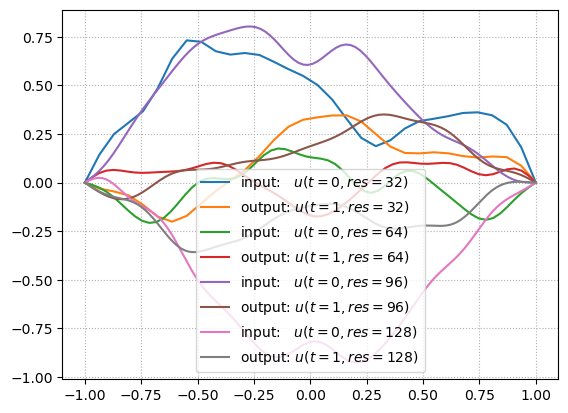

In [202]:
available_res = [32, 64, 96,128]

for res in available_res:
    print("current res = ", res)
    # Load training solution data
    test_data = np.load(f"test_sol_res_{res}.npy", allow_pickle=True)



    # Extract first (t=0) and last (t=1) time snapshots
    n_trajectories_res = test_data.shape[0]
    n_spatial_points_res = test_data.shape[2]

    # Initialize arrays for input (t=0) and output (t=1)
    x_data = np.zeros((n_trajectories_res, n_spatial_points_res, 2))  # 2 for [u(t=0), x]
    y_data = np.zeros((n_trajectories_res, n_spatial_points_res))     # u(t=1)

    print("x_data.shape: ", x_data.shape)

    # Fill the arrays
    for i in range(n_trajectories_res):

        x_data[i, :, 0] = test_data[i, 0, :]    # u(t=0)
        x_data[i, :, 1] = np.linspace(-1, 1, n_spatial_points_res)  # spatial grid
        y_data[i, :] = test_data[i, -1, :]      # u(t=1)
        # if i == 0:
        #     print("x_data[i, :, 0]: ", x_data[i, :, 0])
        #     print("x_data[i, :, 1]: ", x_data[i, :, 1])
        #     print("y_data[i, :]: ", y_data[i, :])

        #     print("test_data[i, :, :]: ", test_data[i, :, :])



    id_sample = 3
    plt.plot(np.linspace(-1,1,x_data.shape[1]),x_data[id_sample,:,0], label = f"input:   $u(t = 0, res = {res})$")
    plt.plot(np.linspace(-1,1,x_data.shape[1]),y_data[id_sample,:], label = f"output: $u(t = 1,res = {res})$")
    plt.grid(True, which="both", ls=":")
    plt.legend()
    plt.show

    # Convert to PyTorch tensors
    input_data_res = torch.from_numpy(x_data).type(torch.float32)
    true_output_res = torch.from_numpy(y_data).type(torch.float32)


    pred_output_res = fno(input_data_res)

    print("relatinve error for res = " , res )
    p = 2
    err = (torch.mean(abs(true_output_res.detach().reshape(-1, ) - pred_output_res.detach().reshape(-1, )) ** p) / torch.mean(abs(true_output_res.detach()) ** p)) ** (1 / p) * 100
    print("Relative L2 error: ", err.item())



# Task 3: Testing on Out-of-Distribution (OOD) Dataset

x_data.shape:  (128, 64, 2)
Relative L2 error for OOD data:  12.371424674987793


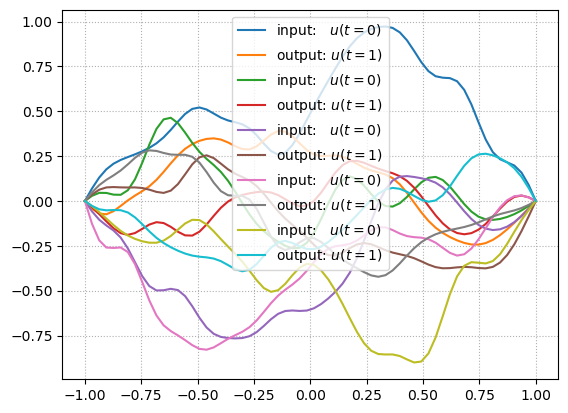

In [203]:
# TASK 3 OOD data


test_data = np.load(f"test_sol_OOD.npy", allow_pickle=True)



# Extract first (t=0) and last (t=1) time snapshots
n_trajectories_ood = test_data.shape[0]
n_spatial_points_ood = test_data.shape[2]

# Initialize arrays for input (t=0) and output (t=1)
x_data = np.zeros((n_trajectories_ood, n_spatial_points_ood, 2))  # 2 for [u(t=0), x]
y_data = np.zeros((n_trajectories_ood, n_spatial_points_ood))     # u(t=1)

print("x_data.shape: ", x_data.shape)

# Fill the arrays
for i in range(n_trajectories_ood):
    x_data[i, :, 0] = test_data[i, 0, :]    # u(t=0)
    x_data[i, :, 1] = np.linspace(-1, 1, n_spatial_points_ood)  # spatial grid
    y_data[i, :] = test_data[i, -1, :]      # u(t=1)

for id_sample in range(5):
    plt.plot(np.linspace(-1,1,x_data.shape[1]),x_data[id_sample,:,0], label = f"input:   $u(t = 0)$")
    plt.plot(np.linspace(-1,1,x_data.shape[1]),y_data[id_sample,:], label = f"output: $u(t = 1)$")
    plt.grid(True, which="both", ls=":")
plt.legend()
plt.show

# Convert to PyTorch tensors
input_data_ood = torch.from_numpy(x_data).type(torch.float32)
true_output_ood = torch.from_numpy(y_data).type(torch.float32)


pred_output_ood = fno(input_data_ood)

p = 2
err = (torch.mean(abs(true_output_res.detach().reshape(-1, ) - pred_output_res.detach().reshape(-1, )) ** p) / torch.mean(abs(true_output_res.detach()) ** p)) ** (1 / p) * 100
print("Relative L2 error for OOD data: ", err.item())


# Task 4: All2All Training

TIME DEPENDENT FNO FOR TASK 5

FIRST IMPLEMENTATION OF tdCNO All2All training then we switch conv1d blocks to spectralconv1d blocks and hopefully it works.

In [258]:
class generate_training_dataset(Dataset):
    def __init__(self, training_samples=64):
        self.data = np.load("train_sol.npy")

        #print("Data shape: ", self.data.shape)

        self.N = self.data.shape[0]  # number of trajectories
        self.T = self.data.shape[1]  # number of time steps
        self.S = self.data.shape[2]  # number of spatial points

        # Use only the specified number of training samples
        self.data = self.data[:training_samples]

        # Precompute all possible (t_initial, t_final) pairs
        self.time_pairs = [(i, j) for i in range(self.T) for j in range(i + 1, self.T)]
        #self.time_pairs = [(0, 1)]
        self.len_times = len(self.time_pairs)
        print("nr of time pairs: ", self.len_times)

        # Total length is number of samples times number of time pairs
        self.length = training_samples * self.len_times

        # Calculate mean and std for normalization if needed
        self.mean = np.mean(self.data)
        self.std = np.std(self.data)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # Calculate which trajectory and which time pair to use
        sample_idx = index // self.len_times
        time_pair_idx = index % self.len_times
        #print("sample index, time_pair index", sample_idx, time_pair_idx)

        t_inp, t_out = self.time_pairs[time_pair_idx]
        delta_time = (t_out - t_inp) * 0.25  # Scale time to [0,1]

        # Get input and output data
        inputs = torch.from_numpy(self.data[sample_idx, t_inp]).type(torch.float32)
        inputs_t = torch.ones_like(inputs).type(torch.float32) * delta_time
        inputs = torch.stack((inputs, inputs_t), 0)  # Stack instead of cat

        outputs = torch.from_numpy(self.data[sample_idx, t_out]).type(torch.float32)

        return delta_time, inputs, outputs
    
    
class generate_test_dataset(Dataset):
    def __init__(self):
        self.data = np.load("test_sol.npy")

        #print("Data shape: ", self.data.shape)

        self.N = self.data.shape[0]
        self.T = self.data.shape[1]
        self.S = self.data.shape[2]
        
    def __len__(self):
        return self.N
    
    def __getitem__(self, index):
        # Get input: u(t=0) and t = 0 
        # get output: u(t=1)
        #print("ind", index)
        delta_time = 1.0 
        #print("test data shape: ", self.data.shape)
        inputs = torch.from_numpy(self.data[index, 0]).type(torch.float32)
        inputs_t = torch.ones_like(inputs).type(torch.float32) * 1
        inputs = torch.stack((inputs, inputs_t), 0)
        
        outputs = torch.from_numpy(self.data[index, -1]).type(torch.float32)        
        return delta_time, inputs, outputs
        

In [259]:

#---------------------
# Time-conditional BN:
#---------------------

class FILM(torch.nn.Module):
    def __init__(self,
                channels,
                use_bn = True):
        super(FILM, self).__init__()
        self.channels = channels

        self.inp2scale = nn.Linear(in_features=1, out_features=channels, bias=True)
        self.inp2bias = nn.Linear(in_features=1, out_features=channels, bias=True)

        self.inp2scale.weight.data.fill_(0)
        self.inp2scale.bias.data.fill_(1)
        self.inp2bias.weight.data.fill_(0)
        self.inp2bias.bias.data.fill_(0)

        if use_bn:
          self.norm = nn.BatchNorm1d(channels)
        else:
          self.norm = nn.Identity()

    def forward(self, x, time):

        x = self.norm(x)
        time = time.reshape(-1,1).type_as(x)
        scale     = self.inp2scale(time)
        bias      = self.inp2bias(time)
        scale = scale.unsqueeze(2).expand_as(x)
        bias  = bias.unsqueeze(2).expand_as(x)

        return x * scale + bias



In [277]:
class tdFNO1d(nn.Module):
    def __init__(self, modes, width):
        super(tdFNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w;
            K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x) --> GRID IS INCLUDED!

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = nn.ReLU()
        self.bn = FILM(channels = self.width)

    def fourier_layer(self, x, time,  spectral_layer, conv_layer, bn = False):
        #print("before spec layer: ", x.shape)  
        # print spec conv1 has param in_channels , out channels, modes 
        #print("spec layer x: ", spectral_layer(x).shape)   
        #print("conv layer x: ", conv_layer(x).shape)
        x = spectral_layer(x) + conv_layer(x)
        if bn:
            x = self.bn(x, time)
        return self.activation(x)

    def linear_layer(self, x, time,  linear_transformation, bn = False):
        x = linear_transformation(x)
        if bn:
          x = self.bn(x, time)
        return self.activation(x)

    def forward(self, x, time):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        # x comes in [B 2 S] ---> [B S 2]
        x = x.permute(0, 2, 1)
        #print("x1: ", x.shape)
        x = self.linear_layer(x, time, self.linear_p, bn = False)
        #print("x2: ", x.shape)

        x = x.permute(0, 2, 1)
        #print("x3: ", x.shape)


        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, time, self.spect1, self.lin0, bn = True)
        #print("x4: ", x.shape)
        x = self.fourier_layer(x, time,  self.spect2, self.lin1, bn = True)
        #print("x5: ", x.shape)
        
        x = self.fourier_layer(x, time,  self.spect3, self.lin2)
        #print("x6: ", x.shape)

        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        #print("x7: ", x.shape)
        x = self.linear_layer(x, time,  self.linear_q)
        #print("x8: ", x.shape)
        x = self.output_layer(x)
        #print("x9: ", x.shape)
        
        x = x.permute(0, 2, 1) 
        return x


In [295]:
n_train = 64 # NOTE: we are training on everything for now -- see if it helps
batch_size = 8
torch.manual_seed(0)
np.random.seed(0)

training_dataset = generate_training_dataset(training_samples=n_train)
training_set = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

testing_dataset = generate_test_dataset()
testing_set = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

print(f"size of the dataset: ", len(training_dataset))
print(f"Number of batches in training set: {len(training_set)}")

print("size of the testing dataset: ", len(testing_dataset))
print(f"Number of batches in testing set: {len(testing_set)}")
#testing_set = DataLoader(testing_dataset("validation"), batch_size=batch_size, shuffle=False)

td_modes =  20
td_width = 32

td_learning_rate = 0.0005
td_epochs = 250 # = 250



td_fno = tdFNO1d(td_modes, td_width) # model

optimizer = Adam(td_fno.parameters(), lr=td_learning_rate, weight_decay = 1e-5)

l = torch.nn.MSELoss()
freq_print = 5
for epoch in range(td_epochs):
    train_mse = 0.0
    for step, (time_batch, input_batch, output_batch) in enumerate(training_set):  # Modified this line
        optimizer.zero_grad()
        #print("the input batch:", input_batch.shape)
        #print("time batch: ", time_batch.shape)
        output_pred_batch = td_fno(input_batch, time_batch)
        #print("pred output shape: ", output_pred_batch.shape)
        #print("true output shape: ", output_batch.shape)
        # change the shape from [B, S] to [B, 1 , S]
        output_batch = output_batch.unsqueeze(1)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)


    # Comment out validation for now since testing_set isn't defined
    if epoch % freq_print == 0:
        
        with torch.no_grad():
            td_fno.eval()
            test_relative_l2 = 0.0
            for step, (delta_t, input_batch, output_batch) in enumerate(testing_set):
                output_pred_batch = td_fno(input_batch, delta_t)
                #print("pred output shape: ", output_pred_batch.shape)
                #print("true output shape: ", output_batch.shape)
                output_batch = output_batch.unsqueeze(1)

                loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
                test_relative_l2 += loss_f.item()
            test_relative_l2 /= len(testing_set)

            train_relative_l2 = 0.0
            for step, (delta_t, input_batch, output_batch) in enumerate(training_set):
                output_pred_batch = td_fno(input_batch, delta_t)
                #print("pred output shape: ", output_pred_batch.shape)
                #print("true output shape: ", output_batch.shape)
                output_batch = output_batch.unsqueeze(1)

                loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
                train_relative_l2 += loss_f.item()

            print(f"#### Epoch: {epoch} ####### Train Loss: {train_mse} ## train relative L2 norm = {train_relative_l2} ### test relative L2 norm: {test_relative_l2}")


nr of time pairs:  10
size of the dataset:  640
Number of batches in training set: 80
size of the testing dataset:  128
Number of batches in testing set: 16
#### Epoch: 0 ####### Train Loss: 0.02501428857212886 ## train relative L2 norm = 7259.774642944336 ### test relative L2 norm: 105.3935694694519
#### Epoch: 5 ####### Train Loss: 0.01191079945419915 ## train relative L2 norm = 3397.141658782959 ### test relative L2 norm: 70.34345316886902
#### Epoch: 10 ####### Train Loss: 0.010317091725300997 ## train relative L2 norm = 3157.4947967529297 ### test relative L2 norm: 67.31333518028259
#### Epoch: 15 ####### Train Loss: 0.008467347628902644 ## train relative L2 norm = 2913.5855445861816 ### test relative L2 norm: 64.25531435012817
#### Epoch: 20 ####### Train Loss: 0.006760799462790601 ## train relative L2 norm = 2502.919569015503 ### test relative L2 norm: 68.34694170951843
#### Epoch: 25 ####### Train Loss: 0.005419788789004088 ## train relative L2 norm = 2401.2811374664307 ### tes

KeyboardInterrupt: 

TIME:  1.0


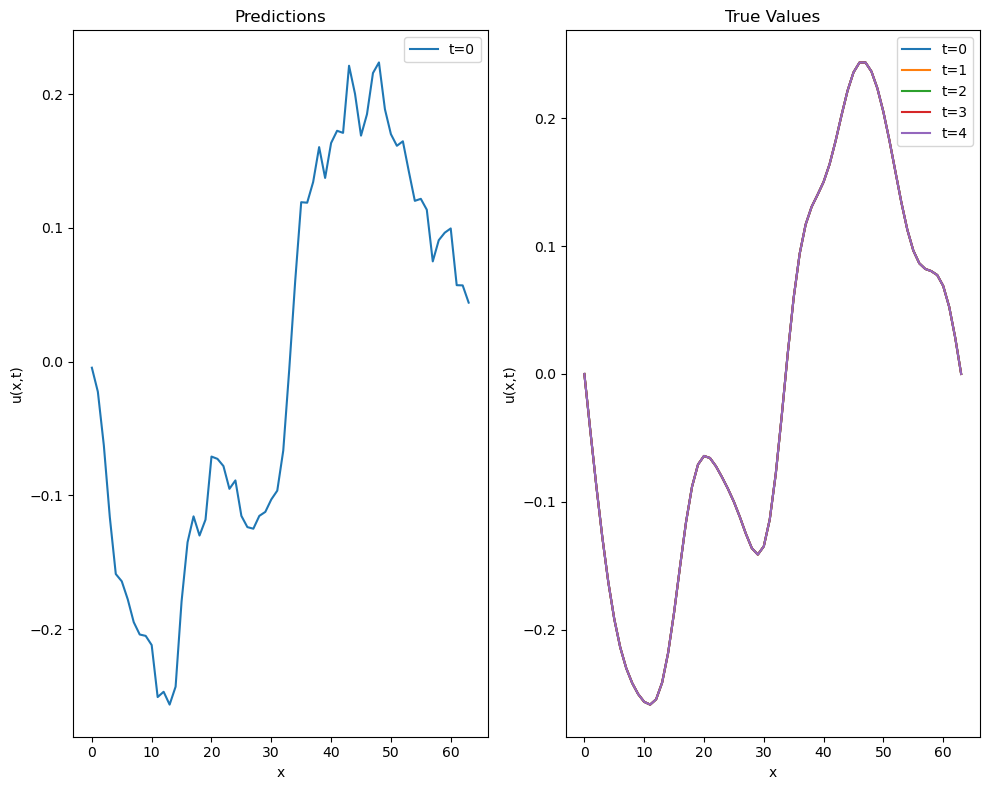

In [294]:

#####PLOTTING####

# Get first dataset from training set
time_batch, input_batch, output_batch = next(iter(training_set))

#print("input batch valss: ", input_batch[0])
# Get predictions
with torch.no_grad():
    td_fno.eval()
    pred = td_fno(input_batch, time_batch)
    #pred = pred.unsqueeze(1)

# Convert to numpy for plotting
pred = pred.cpu().numpy()
true = output_batch.cpu().numpy()

# print("time batch: ", time_batch)

# print(input_batch.shape, output_batch.shape, pred.shape)
pred = pred[0]
input = input_batch[0]
# print("input shape" ,input.shape)
# print("input: ", input)
time = time_batch[0]
print("TIME: ", time.item())
output = output_batch[0]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

# Plot predictions
ax1.set_title('Predictions')
for t in range(min(5, pred.shape[0])):  # Plot t=0,1,2,3,4 or fewer if not available
    ax1.plot(pred[t], label=f't={t}')
ax1.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('u(x,t)')

# Plot true values
ax2.set_title('True Values')
for t in range(min(5, output.shape[0])):  # Plot t=0,1,2,3,4 or fewer if not available
    ax2.plot(output, label=f't={t}')
ax2.legend()
ax2.set_xlabel('x')
ax2.set_ylabel('u(x,t)')

plt.tight_layout()

